# Exploring Energy Consumption Between Croatia and Slovenia Since 1991

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [3]:
np.random.seed(3799)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv')

In [5]:
# Check the amount of rows and features
df.shape

(21812, 130)

In [6]:
# Check how many nans there are in the columns
pd.set_option('display.max_rows', None)
df.isna().sum()[df.isna().sum() > 0]

iso_code                                         5000
population                                       3365
gdp                                             10037
biofuel_cons_change_pct                         20006
biofuel_cons_change_twh                         19016
biofuel_cons_per_capita                         19412
biofuel_consumption                             18936
biofuel_elec_per_capita                         16242
biofuel_electricity                             15978
biofuel_share_elec                              16001
biofuel_share_energy                            19034
carbon_intensity_elec                           15977
coal_cons_change_pct                            16516
coal_cons_change_twh                            16398
coal_cons_per_capita                            17060
coal_consumption                                16293
coal_elec_per_capita                            15718
coal_electricity                                15103
coal_prod_change_pct        

There are an overwhelmingly large amount of NaNs in this dataset. I need a way to focus on the data that showcases a complete view of the data, i.e., something that has a lot of data present. I will attempt to solve this by calculating the percentages of NaNs by each country to determine if there are any countries containing a low amount of NaNs. I want this because imputing or utilizing methods to fill in NaNs to select my desired countries could result in an unrepresentative dataset, so it is best to work with the countries that are most complete.

In [8]:
# reset the display to not show all rows
pd.reset_option('display.max_rows')

In [9]:
# calculate the percentage of NaNs present in each row
df_copy = df.copy()
df_copy['nan_percent'] = df_copy.isna().mean(axis=1) * 100

# group by country and derive the mean of the NaN percentage to find the country with the lowest amount of NaNs
mean_nan_percent_by_country = df_copy.groupby('country')['nan_percent'].mean()

# selecting for countries that have their data with less than 10% of NaNs
print(mean_nan_percent_by_country[mean_nan_percent_by_country < 10])

country
Croatia     7.081448
Slovenia    4.954751
Name: nan_percent, dtype: float64


The criteria of less than 10% of NaNs shows that there are only two countries present that are able to be worked with. We will use these specific countries for our purposes. Now, we will clean the rest of the NaNs in these countries since utilizing particular unsupervised learning methods requires no NaNs to be present.

In [11]:
croatia = df[df['country'] == 'Croatia']

In [12]:
# determine the columns containing NaNs
croatia_nans = croatia.isna().sum()[croatia.isna().sum() > 0]
croatia_nans

gdp                                  1
biofuel_cons_change_pct             19
biofuel_cons_change_twh             18
biofuel_cons_per_capita             17
biofuel_consumption                 17
biofuel_share_energy                17
coal_cons_change_pct                 1
coal_cons_change_twh                 1
coal_prod_change_pct                26
coal_prod_change_twh                10
coal_prod_per_capita                 9
coal_production                      9
energy_cons_change_pct               1
energy_cons_change_twh               1
energy_per_gdp                       1
fossil_cons_change_pct               1
fossil_cons_change_twh               1
gas_cons_change_pct                  1
gas_cons_change_twh                  1
gas_prod_change_pct                 10
gas_prod_change_twh                 10
gas_prod_per_capita                  9
gas_production                       9
hydro_cons_change_pct                1
hydro_cons_change_twh                1
low_carbon_cons_change_pc

In [13]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
croatia.shape

(34, 130)

In [14]:
# remove the columns that contain more than one NaN
croatia_no_nans = croatia.loc[:, croatia.isna().sum() <= 1].copy()

In [15]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder = croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]
croatia_nan_idxs = {col: croatia_no_nans.index[croatia_no_nans[col].isna()].tolist() for col in remainder.index}
croatia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Clearly, the 5007th index is empty, so we can be confident to drop that. Also, the 5040th index has a couple of missing value, which we will drop too.

In [17]:
# drop the 5040th and 5007th indices
croatia_no_nans.drop([5040, 5007], inplace=True)

In [18]:
# double check that there are no more NaNs
croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [19]:
# Set up slovenia to be cleaned
slovenia = df[df['country'] == 'Croatia']

In [20]:
# determine the columns containing NaNs
slovenia_nans = slovenia.isna().sum()[slovenia.isna().sum() > 0]
slovenia_nans

gdp                                  1
biofuel_cons_change_pct             19
biofuel_cons_change_twh             18
biofuel_cons_per_capita             17
biofuel_consumption                 17
biofuel_share_energy                17
coal_cons_change_pct                 1
coal_cons_change_twh                 1
coal_prod_change_pct                26
coal_prod_change_twh                10
coal_prod_per_capita                 9
coal_production                      9
energy_cons_change_pct               1
energy_cons_change_twh               1
energy_per_gdp                       1
fossil_cons_change_pct               1
fossil_cons_change_twh               1
gas_cons_change_pct                  1
gas_cons_change_twh                  1
gas_prod_change_pct                 10
gas_prod_change_twh                 10
gas_prod_per_capita                  9
gas_production                       9
hydro_cons_change_pct                1
hydro_cons_change_twh                1
low_carbon_cons_change_pc

In [21]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
slovenia.shape

(34, 130)

In [22]:
# remove the columns that contain more than one NaN
slovenia_no_nans = slovenia.loc[:, slovenia.isna().sum() <= 1].copy()

In [23]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder_slov = slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]
slovenia_nan_idxs = {col: slovenia_no_nans.index[slovenia_no_nans[col].isna()].tolist() for col in remainder_slov.index}
slovenia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Luckily, the Slovenia data is showing the same missed values that Croatia has, which helps us for comparison their countries for our models.

In [25]:
# drop the 5040th and 5007th indices
slovenia_no_nans.drop([5040, 5007], inplace=True)

In [26]:
# double check that there are no more NaNs
slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [27]:
# assign the variables back to workable names for efficiency
slovenia_df = slovenia_no_nans
croatia_df = croatia_no_nans

In [110]:
# isolate the numerical variables 
croatia_df_numeric = croatia_df.drop(['year', 'country', 'iso_code'], axis =1).copy()
slovenia_df_numeric = slovenia_df.drop(['year', 'country', 'iso_code'], axis =1).copy()

We want to determine the primary means of energy consumption for Slovenia and Croatia. Therefore, we will isolate only the columns that are associated with types of energy consumption.

In [113]:
# isolate the consumption columns
consumption_columns_croatia = [col for col in croatia_df_numeric.columns if 'consumption' in col]
consumption_columns_slovenia = [col for col in slovenia_df_numeric.columns if 'consumption' in col]

In [115]:
# select only the consumption columns in the dataframe
croatia_consumption = croatia_df_numeric[consumption_columns_croatia]
slovenia_consumption = slovenia_df_numeric[consumption_columns_slovenia]

In [117]:
# gather the years for each country to use as indices
years_croatia = croatia_df['year']
years_slovenia = slovenia_df['year']

In [119]:
# scale the data for preparation to be used in the models
croatia_scaled = StandardScaler().fit_transform(croatia_consumption)
slovenia_scaled = StandardScaler().fit_transform(slovenia_consumption)

In [121]:
# put the scaled data back into a dataframe, using the years as indices
croatia_dfscaled = pd.DataFrame(croatia_scaled, columns=croatia_consumption.columns, index=years_croatia.values)
slovenia_dfscaled = pd.DataFrame(slovenia_scaled, columns=slovenia_consumption.columns, index=years_slovenia.values)

In [284]:
slovenia_dfscaled

,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption
1991,-0.153238,-1.175144,-1.445166,-0.456225,-0.828351,0.0,-0.944475,-0.556000,-1.622952,-0.828351,-0.575527,-0.662453
1992,-0.461822,-1.147823,-1.048143,-1.461134,-1.633873,0.0,-0.944475,-0.567048,-2.022605,-1.633873,-0.575527,-0.662453
1993,-0.797890,-0.802002,-0.419524,-1.289508,-1.487351,0.0,-0.613496,-0.531353,-1.596528,-1.487351,-0.575527,-0.662453
1994,-1.510528,-1.010733,-1.122125,-0.533370,-0.892959,0.0,-0.417765,-0.567048,-1.491691,-0.892959,-0.575527,-0.662453
1995,-1.722680,-0.738254,-1.969474,-0.321582,-0.721517,0.0,0.270179,-0.558549,-1.126290,-0.721517,-0.575527,-0.662453
1996,-1.900116,-0.744932,-0.723265,1.540880,0.765849,0.0,-0.094232,-0.558549,-0.344475,0.765849,-0.575527,-0.662453
1997,-1.338396,-0.127482,-0.299131,-0.175960,-0.610992,0.0,0.361206,-0.580646,-0.452371,-0.610992,-0.575527,-0.662453
1998,-1.398184,0.461433,-0.764162,-0.032361,-0.490544,0.0,1.271019,-0.558549,0.204789,-0.490544,-0.575527,-0.662453
1999,-1.545726,0.403392,-0.603791,1.083210,0.400353,0.0,1.191694,-0.558549,0.618633,0.400353,-0.575527,-0.662453
2000,-0.281493,0.044700,-0.499021,0.336318,-0.202116,0.0,0.309690,-0.580646,-0.062014,-0.202116,-0.575527,-0.662453


### PCA

The data is now fully cleaned and prepared. There are no missing values and it is normalized using Standard Scaler. We can now proceed by using PCA.

In [190]:
croatia_dfscaled.shape, slovenia_dfscaled.shape

((32, 12), (32, 12))

In [210]:
# perform PCA with 12 components (the same as the number of columns) for slovenia
pca_croatia = PCA(n_components=12)
X_pca_croatia = pca_croatia.fit_transform(croatia_dfscaled)

In [212]:
# perform PCA with 12 components (the same as the number of columns) for croatia
pca_slovenia = PCA(n_components=12)
X_pca_slovenia = pca_slovenia.fit_transform(slovenia_dfscaled)

In [214]:
# get the proportion of variance of each component
explained_var_croatia = pca_croatia.explained_variance_ratio_

# get the cumulative proportion of variance
cum_explained_var_croatia = np.cumsum(explained_var_croatia)

In [216]:
# slovenia
explained_var_slovenia = pca_slovenia.explained_variance_ratio_
cum_explained_var_slovenia = np.cumsum(explained_var_slovenia)

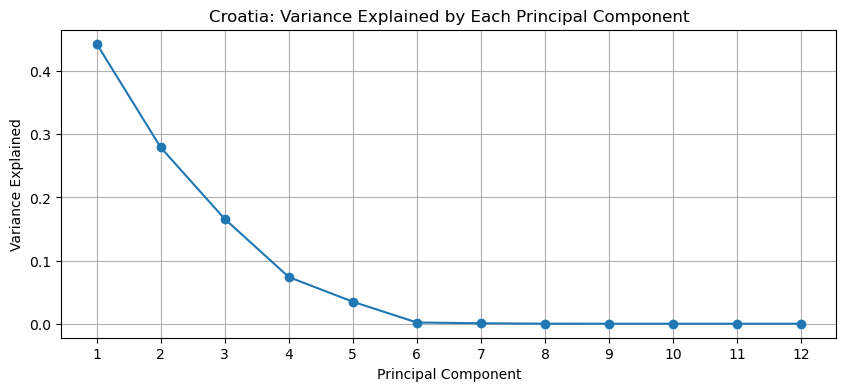

In [218]:
# plot the variance explained by each principal component
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), explained_var_croatia, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Croatia: Variance Explained by Each Principal Component')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

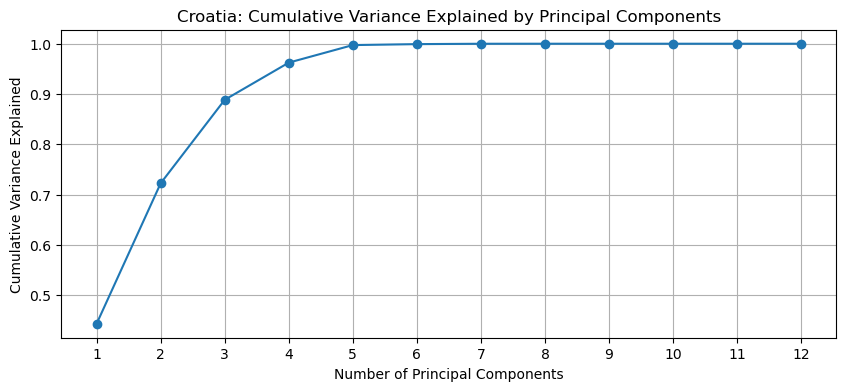

In [220]:
# plot the cumulative proportional variance 
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), cum_explained_var_croatia, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Croatia: Cumulative Variance Explained by Principal Components')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

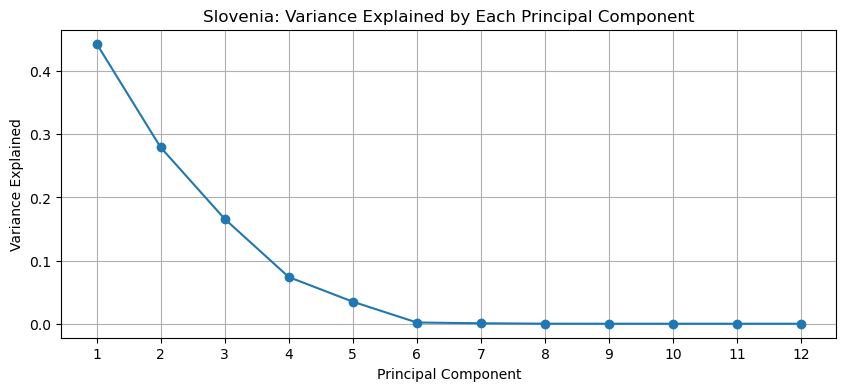

In [226]:
# slovenia
# plot the variance explained by each principal component
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), explained_var_slovenia, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Slovenia: Variance Explained by Each Principal Component')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

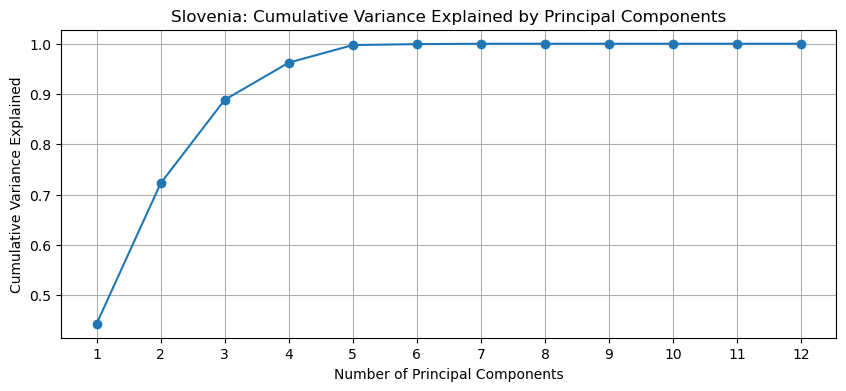

In [224]:
# plot the cumulative proportional variance 
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), cum_explained_var_slovenia, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Slovenia: Cumulative Variance Explained by Principal Components')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### Discuss what the shape of it means about the decomposition:
For both Croatia and Slovenia, the graphs are similar if not the same. It is only the first 5 principal components that contain all of the variance of the data, with the first PC explaining almost half (~46%) of the total variance in explaining the energy consumption for the countries. Let's look closer to determine the weights of the first principal component to determine what features are contributing to this outcome.

In [236]:
# check the weights of each of the features to see what they contribute to with the first PC
loadings = pd.DataFrame(
    pca_croatia.components_.T,
    index=croatia_dfscaled.columns,
    columns=[f'PC{i+1}' for i in range(pca_croatia.n_components_)]
)

print(loadings['PC1']) 

coal_consumption              -1.228719e-01
fossil_fuel_consumption       -3.453921e-01
gas_consumption               -9.985630e-02
hydro_consumption              1.743655e-02
low_carbon_consumption         3.177737e-01
nuclear_consumption            3.469447e-18
oil_consumption               -3.605139e-01
other_renewable_consumption    3.978541e-01
primary_energy_consumption    -1.794979e-01
renewables_consumption         3.177737e-01
solar_consumption              4.035527e-01
wind_consumption               4.123576e-01
Name: PC1, dtype: float64


The first principal component represents a clear difference between renewable/low-carbon energy sources and fossil fuel consumption. Years with higher wind, solar, and other renewable energy use score highly on this component, while years with greater fossil fuel (especially oil and gas) consumption score lower. To figure out how this is changing over time, we can plot the years with the principal components and see how high or low they are.

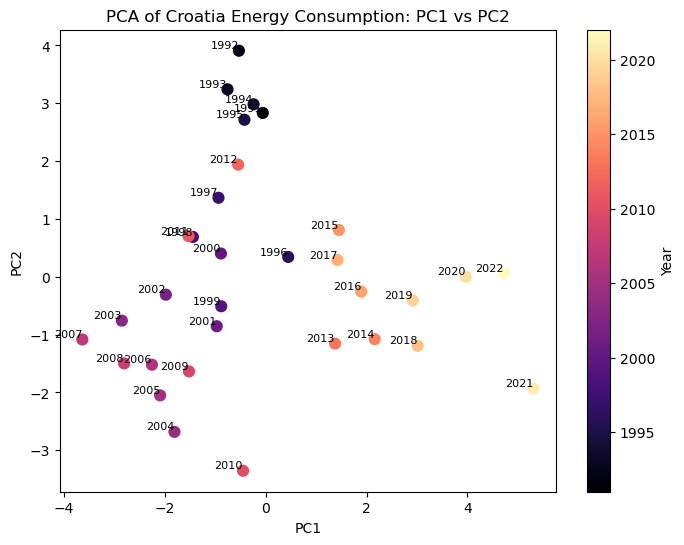

In [228]:
# get the year values to project onto PCA space
years_croatia = croatia_dfscaled.index.values

# Plot PC1 vs PC2 (color by year)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_croatia[:,0], X_pca_croatia[:,1], cmap='magma', c=years, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Croatia Energy Consumption: PC1 vs PC2')
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years_croatia):
    plt.text(X_pca_croatia[i,0], X_pca_croatia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

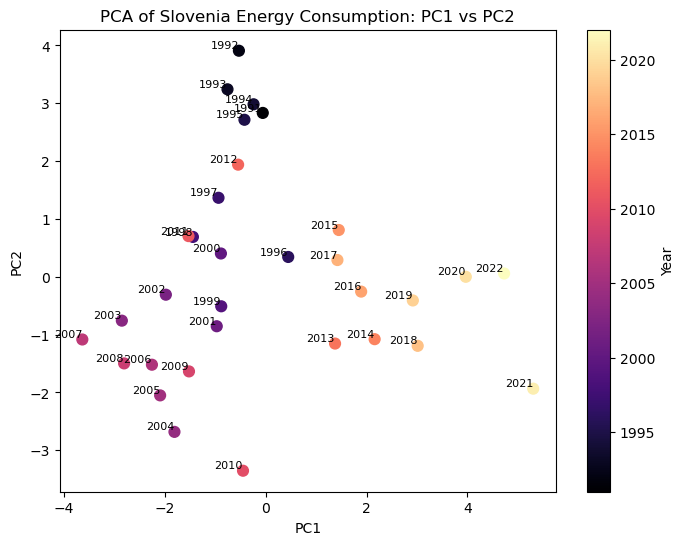

In [230]:
# get the year values to project onto PCA space
years_slovenia = slovenia_dfscaled.index.values

# Plot PC1 vs PC2 (color by year)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_slovenia[:,0], X_pca_slovenia[:,1], cmap='magma', c=years, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Slovenia Energy Consumption: PC1 vs PC2')
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years):
    plt.text(X_pca_slovenia[i,0], X_pca_slovenia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

From these graphs, since the earlier years show low PC1 values and the later years show higher PC1 values, we can reasonably conclude that the main trend in Croatia’s (and Slovenia’s) energy consumption has been a shift from fossil fuels toward renewables over time.

### Compare Slovenia's two features against the first two principal components

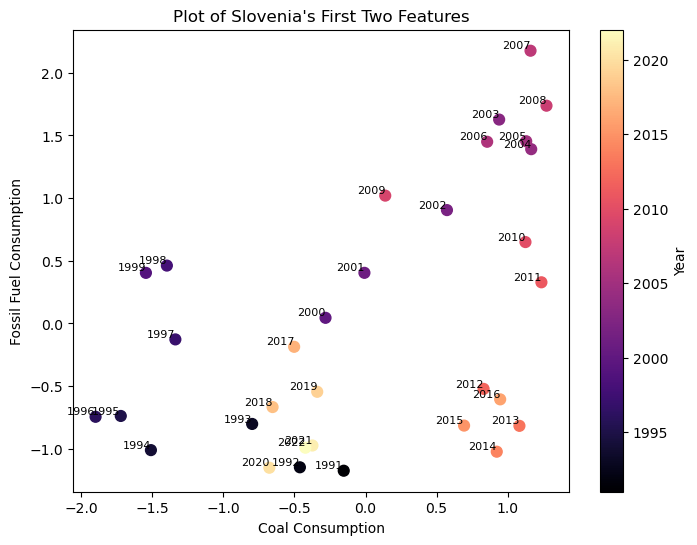

In [286]:
# plot the original two features to compare against PC1/PC2 of the slovenia df
plt.figure(figsize=(8,6))
scatter = plt.scatter(slovenia_dfscaled.iloc[:,0], slovenia_dfscaled.iloc[:,1], cmap='magma', c=years, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Slovenia's First Two Features")
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years):
    plt.text(slovenia_dfscaled.iloc[i,0], slovenia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

For Slovenia's first two principal components, there is a progression over the years, with early years (darker colors, e.g., 1992–1995) clustered at the top, and later years (lighter, e.g., 2020–2022) drifting towards the bottom right. As spoken about earlier when comparing against the first principal component analysis, it was concluded that the first principal component corresponds to there being a shift from fossil fuels toward renewables over time.

For Sloevnia's first two features, there are trends over the years of which type of energy consumption is used. For instance, in the earlier 1990s, there was little coal and fossil fuel consumption (but coal > fossil fuel by a little, e.g., 1991, 1992, and 1993). As the years went into the 2000s, there is a gradual shift in both coal and fossil fuel consumption, but then into the 2010s the fossil fuels dropped while coal consumption stayed very high. Finally, from 2017 onwards, coal consumption began to drift down while fossil fuels still stayed low. 

### How can the U and V* matrix from the SVD (or "x" and "rotation" from PCA) be interpreted?

In [259]:
# peform the decomposition
U, S, Vt = np.linalg.svd(croatia_dfscaled, full_matrices=False)

In [267]:
# inspect the shape of each
U.shape, S.shape, Vt.shape

((32, 12), (12,), (12, 12))

In [263]:
# view one of each item
U[:1], S[:1], Vt[:1]

(array([[ 0.00481905, -0.2857803 ,  0.10067351, -0.18542665, -0.10201403,
          0.14062198,  0.28784931, -0.09846067,  0.07955792,  0.21283215,
         -0.26258272,  0.35323821]]),
 array([12.4932359]),
 array([[ 1.22871923e-01,  3.45392083e-01,  9.98562950e-02,
         -1.74365478e-02, -3.17773732e-01, -3.46944695e-18,
          3.60513853e-01, -3.97854119e-01,  1.79497903e-01,
         -3.17773732e-01, -4.03552698e-01, -4.12357589e-01]]))

Each row of **U** can be interpreted as one observation (in our case, each year) that has 12 scores, each one representing the principal component it is associated with (e.g., the first index in the row represents the first principal component). All these observations indicate how each load onto each principal component. For example, taking the first column of U (PC1), it shows us how all the years are being loaded/projected onto the first principal component.

Each row of **Vt** can be interpreted as how each feature is weighted on each principal component. So the larger the value (in magnitude), the more that feature influences the corresponding principal component, and positive and negative values show whether the feature contributes in the same direction as the component or in the opposite direction. Therefore, if one looks at the first row of Vt, it can be seen which features are most responsible for the variation captured by the first principal component.

## K-Means Clustering

In [310]:
# Find optimal cluster amount using silhouette score vs inertia
inertia_ct = []
inertia_sv = []
silh_ct = []
silh_sv = []

for k in range(2, 15):
    kmeans_ct = KMeans(n_clusters=k).fit(croatia_dfscaled)
    kmeans_sv = KMeans(n_clusters=k).fit(slovenia_dfscaled)
    inertia_ct.append(kmeans_ct.inertia_)
    inertia_sv.append(kmeans_sv.inertia_)
    silh_ct.append(silhouette_score(croatia_dfscaled, kmeans_ct.labels_))
    silh_sv.append(silhouette_score(slovenia_dfscaled, kmeans_sv.labels_))

C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

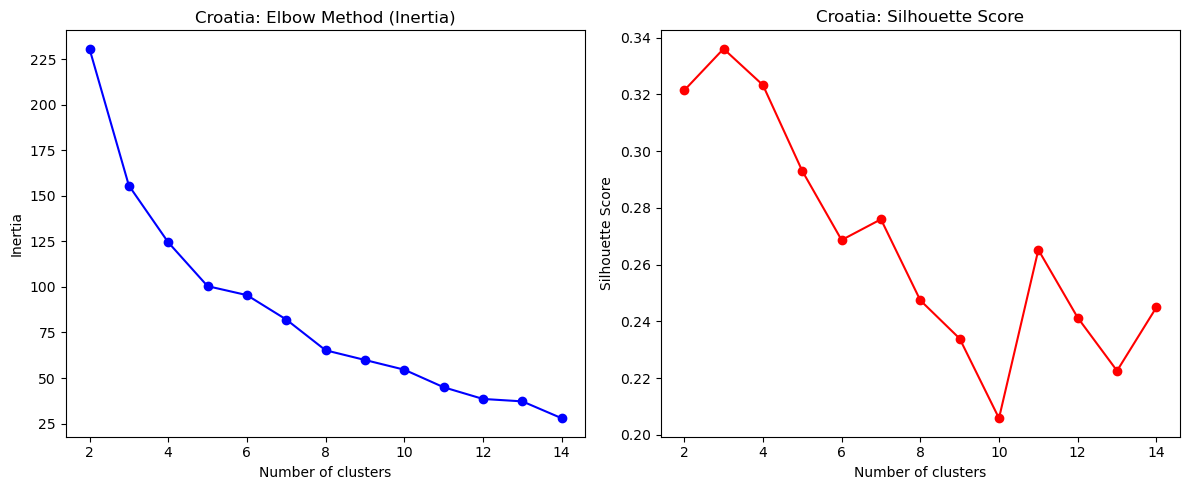

In [312]:
K = range(2, 15)

# plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# elbow plot
ax1.plot(K, inertia_ct, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Croatia: Elbow Method (Inertia)')

# silhouette plot
ax2.plot(K, silh_ct, 'ro-')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Croatia: Silhouette Score')

plt.tight_layout()
plt.show()

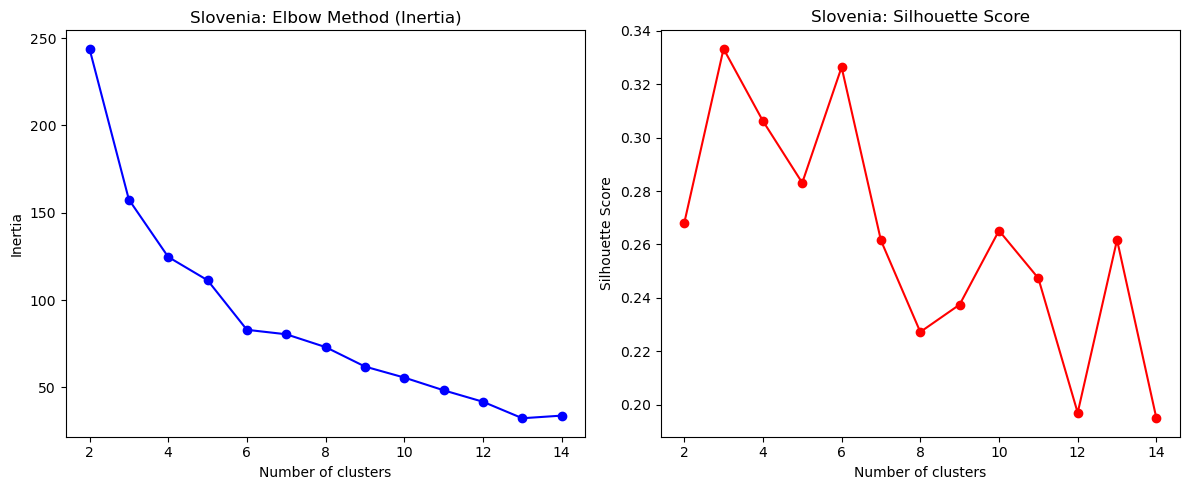

In [314]:
# plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# elbow plot
ax1.plot(K, inertia_sv, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Slovenia: Elbow Method (Inertia)')

# silhouette plot
ax2.plot(K, silh_sv, 'ro-')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Slovenia: Silhouette Score')

plt.tight_layout()
plt.show()

Based on the silhouette vs inertia scores for both Croatia and Slovenia, a good number of clusters is 3 because this is where the silhouette score is highest for each country and where there is a large drop in inertia. It isn't quite at the elbow yet, but we are informed to pick this because of the silhouette score.

In [319]:
# Fit to the decided number of clusters, concluded from inertia vs silh plots
kmeans_ct = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(croatia_dfscaled)
kmeans_sv = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(slovenia_dfscaled)

C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [321]:
# get the cluster labels and assign them to the respected df
croatia_dfscaled['Cluster'] = kmeans_ct.labels_
slovenia_dfscaled['Cluster'] = kmeans_sv.labels_

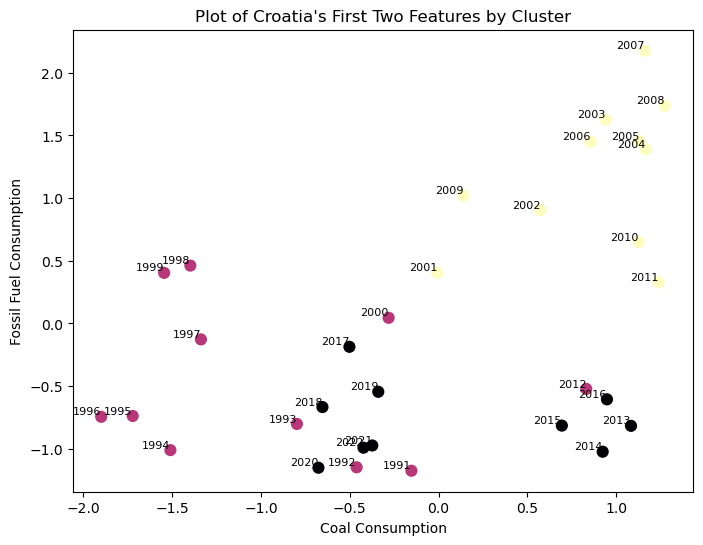

In [335]:
# CROATIA: plot the original two features with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(croatia_dfscaled.iloc[:,0], croatia_dfscaled.iloc[:,1], cmap='magma', c=kmeans_ct.labels_, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Croatia's First Two Features by Cluster")
for i, year in enumerate(years):
    plt.text(croatia_dfscaled.iloc[i,0], croatia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

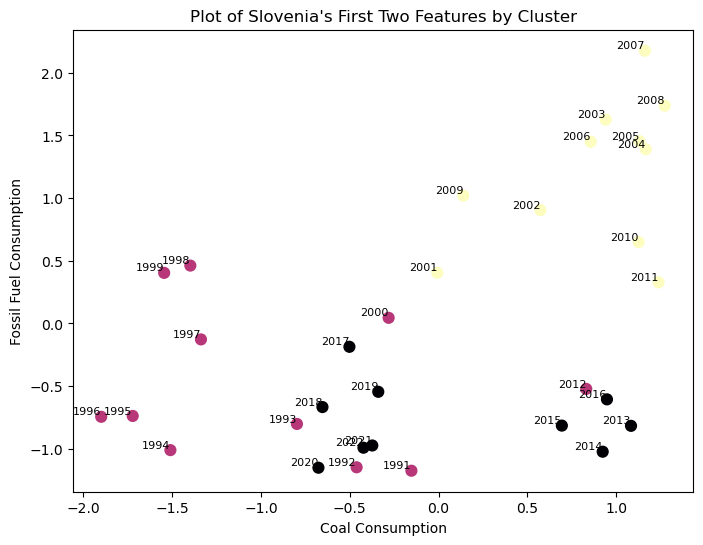

In [337]:
# SLOVENIA: plot the original two features with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(slovenia_dfscaled.iloc[:,0], slovenia_dfscaled.iloc[:,1], cmap='magma', c=kmeans_sv.labels_, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Slovenia's First Two Features by Cluster")
for i, year in enumerate(years):
    plt.text(slovenia_dfscaled.iloc[i,0], slovenia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

In [347]:
# fit on pca components
kmeans_pca_ct = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(X_pca_croatia)
kmeans_pca_sv = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(X_pca_slovenia)

C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


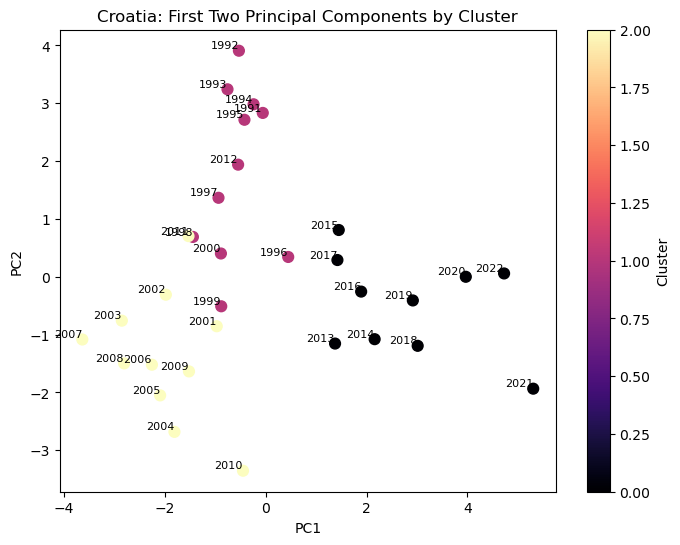

In [349]:
# CROATIA: plot the first two principal components with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_croatia[:,0], X_pca_croatia[:,1], cmap='magma', c=kmeans_pca_ct.labels_, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Croatia: First Two Principal Components by Cluster")
for i, year in enumerate(years):
    plt.text(X_pca_croatia[i,0], X_pca_croatia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.colorbar(scatter, label='Cluster')
plt.show()

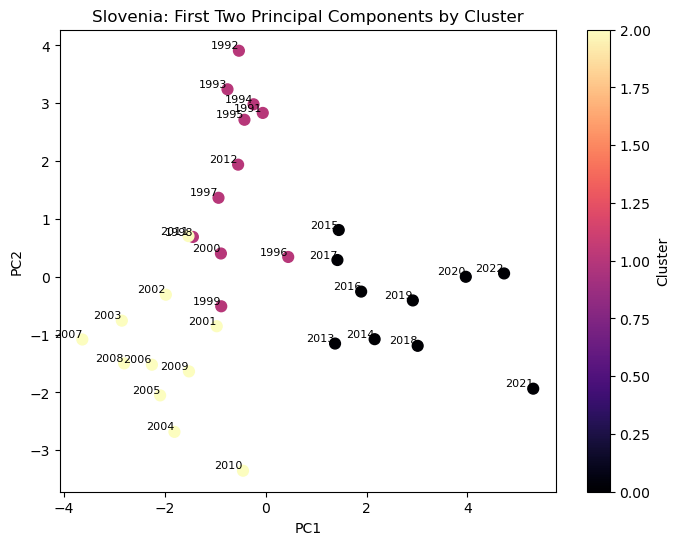

In [351]:
# SLOVENIA: plot the first two principal components with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_slovenia[:,0], X_pca_slovenia[:,1], cmap='magma', c=kmeans_pca_sv.labels_, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Slovenia: First Two Principal Components by Cluster")
for i, year in enumerate(years):
    plt.text(X_pca_slovenia[i,0], X_pca_slovenia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.colorbar(scatter, label='Cluster')
plt.show()

For both the first two features and the first two principal components, there is clear clustering based on the years. So we will take a closer look into the structure of the features within these clusters for patterns.

In [365]:
# Look closer at the structure of Croatia's feature space 
for i in range(3):
    print(f"Cluster {i}:")
    print(croatia_dfscaled[croatia_dfscaled['Cluster'] == i].index.tolist())
    print(croatia_dfscaled[croatia_dfscaled['Cluster'] == i].mean())
    print()

Cluster 0:
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
coal_consumption               0.067931
fossil_fuel_consumption       -0.777705
gas_consumption               -0.104250
hydro_consumption              0.054637
low_carbon_consumption         0.990476
nuclear_consumption            0.000000
oil_consumption               -0.960234
other_renewable_consumption    1.191499
primary_energy_consumption    -0.258403
renewables_consumption         0.990476
solar_consumption              1.260094
wind_consumption               1.324761
Cluster                        0.000000
dtype: float64

Cluster 1:
[1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2012]
coal_consumption              -0.934430
fossil_fuel_consumption       -0.487200
gas_consumption               -0.754846
hydro_consumption             -0.241338
low_carbon_consumption        -0.626577
nuclear_consumption            0.000000
oil_consumption               -0.065608
other_renewable_consumption   -0.5

### Evaluation of Croatia's Clustering Results

**Cluster 0**: 2013–2022
* High in: Low-carbon consumption, renewables, solar, wind, and other renewable consumption (all strongly positive scores).
* Low in: Fossil fuel, oil, and primary energy consumption.
* Coal and hydro: Around average (near zero).

These are recent years where Croatia has made a significant shift toward renewables (especially solar and wind) while reducing fossil fuel and oil consumption. This reflects a period of strong adoption of clean energy sources and decline in fossil fuel dependence.

**Cluster 1**: 1991–2000, 2012
* Low in: Coal, gas, hydro, low-carbon, other renewables, renewables, solar, wind, and primary energy.
* Near average: Oil (slightly negative), fossil fuels (moderately negative).
* Nuclear: Always zero (no nuclear for all years).

This group consists mostly of early years (the 1990s) and one transitional year (2012), characterized by lower overall energy use and particularly low renewable adoption. It likely reflects Croatia’s energy profile before significant changes toward renewables began.

**Cluster 2**: 2001–2011
* High in: Coal, fossil fuel, gas, oil, and primary energy consumption.
* Low in: Low-carbon, renewables, solar, wind, and other renewables (all negative).
* Hydro: Slightly above average.

These are the mid-years, where fossil fuel consumption (including coal, gas, and oil) was at its highest and renewables were not yet widely adopted. This period may represent an era of increased industrial activity and high energy demand before the transition to renewables.

## Heirarchical Clustering

## Matrix Completion